In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import os, sys
import toml
config = toml.load('../../../../configuration/input_configuration.toml')
%matplotlib inline

# os.chdir('..\..\..\..')
print(os.getcwd())

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


C:\Workspace\sc_2023_base_year_reset\scripts\summarize\notebooks\validation


In [15]:
working_dir = r'outputs/agg/dash'
# pd.options.display.float_format = '{:0,.0f}'.format
format_percent = "{:,.2%}".format

In [16]:
def load_data(fname):
    """ open and join model and survey data """

    df_model = pd.read_csv(os.path.join(working_dir,fname+'.csv'))
    df_model['source'] = 'model'
    df_survey = pd.read_csv(os.path.join(working_dir,'survey',fname+'.csv'))
    df_survey['source'] = 'survey'
    df = df_model.append(df_survey)

    return df

In [17]:
parcel_geog = pd.read_sql_table('parcel_'+config['base_year']+'_geography', 'sqlite:///../../../../inputs/db/'+config['db_name'],
        columns=['CountyName','ParcelID'])

# Usual School Distance

In [18]:
person = pd.read_csv(r'../../../../outputs/daysim/_person.tsv', delim_whitespace=True)
person_survey = pd.read_csv(r'../../../../inputs/base_year/survey/_person.tsv', delim_whitespace=True)

person['source'] = 'model'
person_survey['source'] = 'survey'

In [19]:
person = person.append(person_survey)
person = person.merge(parcel_geog, left_on='pspcl', right_on='ParcelID', how='left')

In [20]:
person['wt_psautime'] = person['psautime']*person['psexpfac']
person['wt_psaudist'] = person['psaudist']*person['psexpfac']

### Average Distance for **All Students**

In [21]:
df = person[(person['pstaz'] > 0) & (person['psaudist'] > 0)]
df.groupby('source').sum()['wt_psaudist']/df.groupby('source').sum()['psexpfac']

source
model     4.446601
survey    5.358698
dtype: float64

#### Average Distance by School County

In [22]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_psaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_psaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,4.633877,6.006208
Kitsap,3.656521,4.351650
Pierce,4.858911,5.317755
Snohomish,3.571923,3.185030


### Average Distance for **University** Students only

In [23]:
df = person[(person['pstaz'] > 0) & (person['psaudist'] > 0) & (person['pptyp'] == 5)]
df.groupby('source').sum()['wt_psaudist']/df.groupby('source').sum()['psexpfac']

source
model      6.783407
survey    22.707938
dtype: float64

#### Average Distance by School County

In [24]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_psaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_psaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,6.270729,22.538617
Kitsap,6.440869,10.938757
Pierce,8.657883,31.797339
Snohomish,6.260721,23.560000


#### Top 10 University TAZs

In [25]:
_df = person_survey[person_survey['pptyp'] == 5]
_df = _df[_df['psaudist'] > 0]
# Top 10 College Destinations
n = 10
top10_college = _df['pstaz'].value_counts()[:n].index.tolist()

_df['wt_psaudist'] = _df['psaudist']*_df['psexpfac']
survey_avg = _df[_df['pstaz'].isin(top10_college)].groupby('pstaz').sum()[['psexpfac','wt_psaudist']]
survey_avg['average_survey'] = survey_avg['wt_psaudist']/survey_avg['psexpfac']

# add survey count as we;ll
person_count = person_survey[(person_survey['pptyp'] == 5) & (person_survey['psaudist'] >0)]
person_count = person_count.groupby('pstaz').count()[['hhno']].reset_index()
person_count.rename(columns={'hhno': 'sample_count'}, inplace=True)
survey_avg = survey_avg.merge(person_count, left_index=True, right_on='pstaz')

In [26]:
model_avg = person[person['pptyp'] == 5]
model_avg = model_avg[model_avg['psaudist'] > 0]
model_avg = model_avg[model_avg['pstaz'].isin(top10_college)].groupby('pstaz').sum()[['psexpfac','psaudist']]
model_avg['average_model'] = model_avg['psaudist']/model_avg['psexpfac']
model_avg = model_avg.reset_index()

In [27]:
_df = model_avg[['average_model','pstaz']].merge(survey_avg[['average_survey','sample_count','pstaz']], on='pstaz')
# _df[~_df.average_survey.isnull()]
_df

,average_model,pstaz,average_survey,sample_count
0,5.872276,72,6.530000,4
1,3.184064,302,8.829749,86
2,1.545449,552,4.097812,8
3,2.387740,584,4.747191,10
4,0.134250,585,13.310000,3
5,2.964483,1715,5.853290,3
6,4.198340,1798,18.134351,14
7,9.107955,2252,23.560000,4
8,0.017821,2867,3.903115,3
9,5.704620,3596,11.075583,3


#### Average Distance for **High School Students 16+** 

In [28]:
df = person[(person['pstaz'] > 0) & (person['psaudist'] > 0) & (person['pptyp'] == 6)]
df.groupby('source').sum()['wt_psaudist']/df.groupby('source').sum()['psexpfac']

source
model     4.555298
survey    4.914839
dtype: float64

In [29]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_psaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_psaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,4.740875,4.394065
Kitsap,3.945822,6.680627
Pierce,4.627713,6.684069
Snohomish,4.161728,2.844952


### Average Distance for **Kids Age 5-15**

In [30]:
df = person[(person['pstaz'] > 0) & (person['psaudist'] > 0) & (person['pptyp'] == 7)]
df.groupby('source').sum()['wt_psaudist']/df.groupby('source').sum()['psexpfac']

source
model     2.685389
survey    3.180424
dtype: float64

#### Average Distance by School County

In [31]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_psaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_psaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,2.650402,3.284497
Kitsap,2.608011,3.091378
Pierce,2.732369,3.310850
Snohomish,2.741533,2.671638


## Usual School Location Distance Distribution (miles)
Percent of Total, bins of 1 mile up to 60 miles

All Students

<AxesSubplot:xlabel='psaudist_bin'>

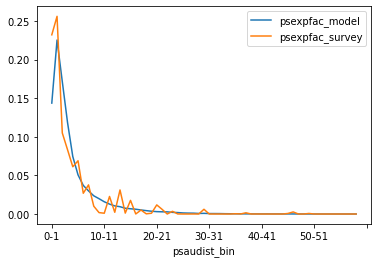

In [32]:
# Create bins
max_bin = 60
person['psaudist_bin'] = pd.cut(person['psaudist'], bins=range(0,max_bin), labels=[str(i)+'-'+str(i+1) for i in range(0,max_bin-1)])
df1 = person[(person['source'] == 'model') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0)]
df2 = person[(person['source'] == 'survey') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot()

Bins of 5 miles, up to 50 miles

In [33]:
range(0,max_bin,5)

range(0, 60, 5)

<AxesSubplot:xlabel='psaudist_bin'>

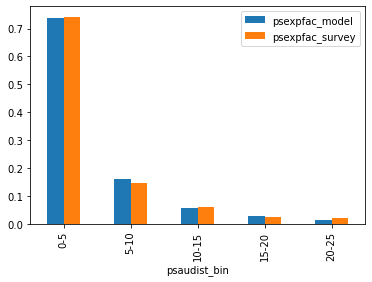

In [34]:
# Create bins
max_bin = 30
person['psaudist_bin'] = pd.cut(person['psaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,5)])
df1 = person[(person['source'] == 'model') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0)]
df2 = person[(person['source'] == 'survey') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot(kind='bar')

### College Student Usual School Distance

College Students: 162569


<AxesSubplot:xlabel='psaudist_bin'>

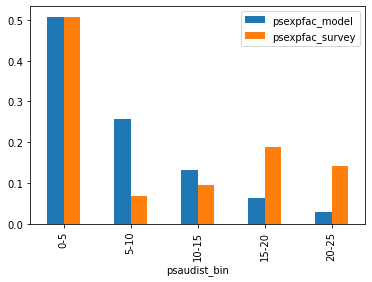

In [35]:
# By studnet type (persontype == 5, 6, 7 )
max_bin = 30
ptype = 5
person['psaudist_bin'] = pd.cut(person['psaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,int(max_bin/6))])
df1 = person[(person['source'] == 'model') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0) & (person['pptyp'] == ptype)]
df2 = person[(person['source'] == 'survey') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0) & (person['pptyp'] == ptype)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
print('College Students: ' + str(len(person[person['pptyp'] == ptype])))
df.plot(kind='bar')

### High School Student 16+ School Distance

High School Students 16+: 127645


<AxesSubplot:xlabel='psaudist_bin'>

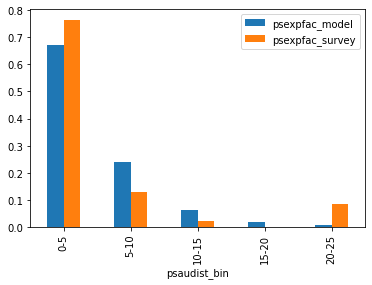

In [36]:
# By studnet type (persontype == 5, 6, 7 )
max_bin = 30
ptype = 6
person['psaudist_bin'] = pd.cut(person['psaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,int(max_bin/6))])
df1 = person[(person['source'] == 'model') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0) & (person['pptyp'] == ptype)]
df2 = person[(person['source'] == 'survey') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0) & (person['pptyp'] == ptype)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
print('High School Students 16+: ' + str(len(person[person['pptyp'] == ptype])))
df.plot(kind='bar')

### Age 5-15 Student School Distance

Students Age 5-15: 557791


<AxesSubplot:xlabel='psaudist_bin'>

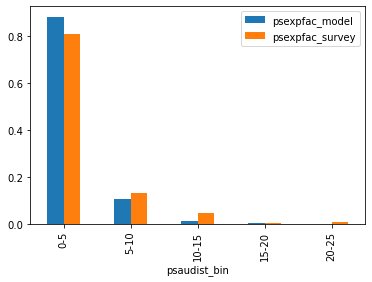

In [37]:
# By studnet type (persontype == 5, 6, 7 )
max_bin = 30
ptype = 7
person['psaudist_bin'] = pd.cut(person['psaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,int(max_bin/6))])
df1 = person[(person['source'] == 'model') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0) & (person['pptyp'] == ptype)]
df2 = person[(person['source'] == 'survey') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0) & (person['pptyp'] == ptype)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
print('Students Age 5-15: ' + str(len(person[person['pptyp'] == ptype])))
df.plot(kind='bar')